In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
inputs = keras.Input(shape=(128,128,3),name='img')

x = layers.Conv2D(
    filters=64, # 卷积层神经元（卷积核）数目
    kernel_size=9, # 感受野的大小
    padding='same', # padding 策略valid或者same
    activation='relu'
    )(inputs)


x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation='relu'
)(x)


outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,          
    padding='same'          # 不设置激活函数
)(x)

model = keras.Model(inputs=inputs,outputs=outputs,name="SRCNN_model")# 通过在图层图中指定其输入和输出来创建一个model

model.summary() # 查看模型摘要，需要模型built（实例化）后调用

Model: "SRCNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
 
from tensorflow.keras import backend as K
import numpy as np
import os
 
import sys
from six.moves import cPickle
 
def load_batch(fpath, label_key='labels'):
    """Internal utility for parsing CIFAR data.
    # Arguments
        fpath: path the file to parse.
        label_key: key for label data in the retrieve
            dictionary.
    # Returns
        A tuple `(data, labels)`.
    """
    with open(fpath, 'rb') as f:
        if sys.version_info < (3,):
            d = cPickle.load(f)
        else:
            d = cPickle.load(f, encoding='bytes')
            # decode utf8
            d_decoded = {}
            for k, v in d.items():
                d_decoded[k.decode('utf8')] = v
            d = d_decoded
    data = d['data']
    labels = d[label_key]
 
    data = data.reshape(data.shape[0], 3, 32, 32)
    return data, labels
 
 
def load_data(ROOT):
    """Loads CIFAR10 dataset.
    # Returns
        Tuple of Numpy arrays: `(x_train, y_train), (x_test, y_test)`.
    """
    #dirname = 'cifar-10-batches-py'
    #origin = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
    #path = get_file(dirname, origin=origin, untar=True)
    path = ROOT
 
    num_train_samples = 50000
 
    x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
    y_train = np.empty((num_train_samples,), dtype='uint8')
 
    for i in range(1, 6):
        fpath = os.path.join(path, 'data_batch_' + str(i))
        (x_train[(i - 1) * 10000: i * 10000, :, :, :],
         y_train[(i - 1) * 10000: i * 10000]) = load_batch(fpath)
 
    fpath = os.path.join(path, 'test_batch')
    x_test, y_test = load_batch(fpath)
 
    y_train = np.reshape(y_train, (len(y_train), 1))
    y_test = np.reshape(y_test, (len(y_test), 1))
 
    if K.image_data_format() == 'channels_last':
        x_train = x_train.transpose(0, 2, 3, 1)
        x_test = x_test.transpose(0, 2, 3, 1)
 
    return (x_train, y_train), (x_test, y_test)

In [11]:

import cv2 as cv
import numpy as np
'''
CIFAR10 had't 128*128*3 images use bicubic alternatived,and bicubic use nearest alternatived.
X_: image applied bicubic interpolation (low-resolution),(50000, 128, 128, 3)
y_: image with original resolution (high-resolution),(10000, 128, 128, 3)
'''

cifar10_dir = './data/cifar-10-batches-py/'

ishape = 128

#load data
(train_images, train_labels), (test_images, test_labels) = load_data(cifar10_dir)

# 缩小数据集，控制内存占用
train_image = train_images[0:10000]
test_image = test_images[0:1000]


# 制造数据 双三次(bicubic)插值将低分辨率图像32*32 放大成目标尺寸 128*128
X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_image]) / 255.
 
y_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in train_image]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_CUBIC) for i in test_image]) / 255.


#### 开始训练

In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',
              metrics=['mae'])

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2) # 评估模型

print('Test Loss:',test_scores[0])
print('Test mae:',test_scores[1])

# Save entire model to a HDF5 file
model.save('SRCNN.h5')

Epoch 1/3
125/125 [==============================] - 285s 2s/step - loss: 0.0331 - mae: 0.0843 - val_loss: 0.0048 - val_mae: 0.0391
Epoch 2/3
125/125 [==============================] - 274s 2s/step - loss: 0.0035 - mae: 0.0336 - val_loss: 0.0028 - val_mae: 0.0305
Epoch 3/3
125/125 [==============================] - 264s 2s/step - loss: 0.0027 - mae: 0.0305 - val_loss: 0.0025 - val_mae: 0.0296
32/32 - 6s - loss: 0.0025 - mae: 0.0298 - 6s/epoch - 178ms/step
Test Loss: 0.002489074133336544
Test mae: 0.029798462986946106


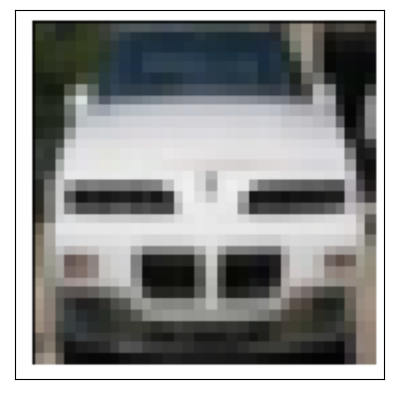

In [17]:
from matplotlib import pyplot as plt

ishape = 128

# 加载放大图像并显示
img = cv.imread('nearest.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)# (36,36,3)->(128,128,3)
 
plt.imshow(img)
 
plt.xticks([]), plt.yticks([])
 
plt.show()

1/1 [==============================] - 0s 123ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


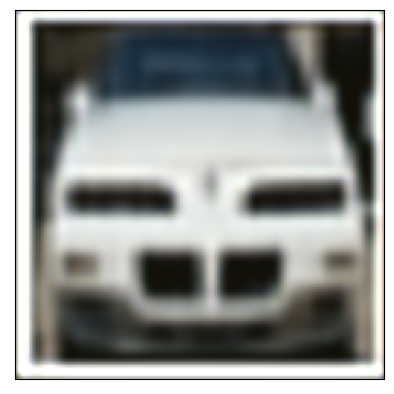

In [18]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.
 
# 处理图像超分辨率
img_SR = model.predict(img)
 
plt.imshow(img_SR[0])
 
plt.xticks([]), plt.yticks([])
 
plt.show()